# Data Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from itertools import accumulate
import six
nan = np.nan

fantasy_21_raw = pd.read_csv ('../data/fantasy_21.csv')
fantasy_22_raw = pd.read_csv ('../data/fantasy_22.csv')
teams_fifa_21_raw = pd.read_csv ('../data/teams_fifa22.csv')
teams_fifa_22_raw = pd.read_csv ('../data/teams_fifa23.csv')
matches_21_raw = pd.read_csv ('../data/matches_21.csv')
matches_22_raw = pd.read_csv ('../data/matches_22.csv')

In [2]:
#creates matches_21 dataset (contains all matches from 2021 season)
matches_21 = matches_21_raw[["Date", "Time","HomeTeam", "AwayTeam", "FTR", "Referee", "B365H", "B365D", "B365A"]]
matches_21 = matches_21.assign(HICT="")
matches_21 = matches_21.assign(AICT="")
matches_21.sort_index(inplace=True)
matches_21 = matches_21.reset_index(drop=True)

In [3]:
#creates fifa 21 dataset
fifa_21 = teams_fifa_21_raw[['Name','Overall']]
fifa_21 = fifa_21.head(20)
fifa_21 = fifa_21.sort_values(['Name'])
fifa_21['Overall'] = fifa_21['Overall'].apply(lambda x: x*100)

#creates list of overall team scores 
overall_21_away = fifa_21.Overall.to_list()
overall_21_home = fifa_21.Overall.to_list()

In [4]:
#creates fifa 22 dataset
fifa_22 = teams_fifa_22_raw[['Name','Overall']]
fifa_22 = fifa_22.head(21)
fifa_22 = fifa_22[fifa_22.Name != 'AFC Richmond'].reset_index(drop = True)
fifa_22 = fifa_22.replace('AFC Bournemouth', 'Bournemouth')
fifa_22 = fifa_22.sort_values(['Name'])
fifa_22['Overall'] = fifa_22['Overall'].apply(lambda x: x*100)

#creates list of overall team scores 
overall_22_away = fifa_22.Overall.to_list()
overall_22_home = fifa_22.Overall.to_list()

In [5]:
#creates matches_22 dataset (contains all matches from 2022 season)
matches_22 = matches_22_raw[["Date", "GW","HomeTeam", "AwayTeam", "FTR", "Referee", "B365H", "B365D", "B365A"]]
matches_22 = matches_22.assign(HICT="")
matches_22 = matches_22.assign(AICT="")
matches_22.sort_index(inplace=True)
matches_22 = matches_22.reset_index(drop=True)

In [6]:
#creates ICT score dataset for 2021 season
fantasy_21_raw[['Date', 'Time']] = fantasy_21_raw['kickoff_time'].str.split('T', 1, expand=True)
fantasy_21 = fantasy_21_raw[["team", "ict_index", "Date", 'minutes']] 
fantasy_21 = fantasy_21.sort_values(by=['team', 'Date'])
fantasy_21 = fantasy_21.groupby(by=['team', 'Date'])['ict_index'].sum().to_frame()
ICT_2021 = fantasy_21.pivot_table(index=['team'], 
            columns=['Date'], values='ict_index').fillna(0)
ICT_2021.sort_index(inplace=True)
ICT_2021.reset_index(inplace=True)

In [7]:
#creates ICT score dataset for 2022 season
fantasy_22 = fantasy_22_raw[["team", "ict_index", "GW", 'minutes']]  
fantasy_22 = fantasy_22.sort_values(by=['team', 'GW'])
fantasy_22 = fantasy_22.groupby(by=['team', 'GW'])['ict_index'].sum().to_frame()
ICT_2022 = fantasy_22.pivot_table(index=['team'], 
            columns=['GW'], values='ict_index').fillna(0)
ICT_2022.sort_index(inplace=True)
ICT_2022.reset_index(inplace=True)

In [8]:
#creates boolean dataset showing when each team was home for 2021 season
fantasy_21 = fantasy_21_raw[["team", "was_home", "Date"]]
fantasy_21 = fantasy_21.sort_values(by=['team', 'Date'])
WH_2021 = fantasy_21.pivot_table(index=['team'], 
            columns=['Date'], values='was_home').fillna(0)
WH_2021.sort_index(inplace=True)
WH_2021.reset_index(inplace=True)

In [9]:
#creates boolean dataset showing when each team was home for 2022 season
fantasy_22 = fantasy_22_raw[["team", "was_home", "GW"]]
fantasy_22 = fantasy_22.sort_values(by=['team', 'GW'])
WH_2022 = fantasy_22.pivot_table(index=['team'], 
            columns=['GW'], values='was_home').fillna(0)
WH_2022.sort_index(inplace=True)
WH_2022.reset_index(inplace=True)

In [10]:
#helper funtions

#returns average of list
def Average(lst):
    return sum(lst) / len(lst)

#returns scores of each team
def get_score_21_away():
    empty_list_21 = []
    for score in overall_21_away:
        if score not in empty_list_21:
            empty_list_21.append(score)
            overall_21_away.remove(score)
            return score

def get_score_22_away():
    empty_list_22 = []
    for score in overall_22_away:
        if score not in empty_list_22:
            empty_list_22.append(score)
            overall_22_away.remove(score)
            return score
        
def get_score_21_home():
    empty_list_21 = []
    for score in overall_21_home:
        if score not in empty_list_21:
            empty_list_21.append(score)
            overall_21_home.remove(score)
            return score

def get_score_22_home():
    empty_list_22 = []
    for score in overall_22_home:
        if score not in empty_list_22:
            empty_list_22.append(score)
            overall_22_home.remove(score)
            return score

In [11]:
#sorts matches 21 dataset by date and awayteam and converts to datetime object
matches_21['Date'] = pd.to_datetime(matches_21['Date'], format='%m/%d/%y')
matches_21 = matches_21.sort_values(['AwayTeam','Date']).reset_index(drop=True)

#combines matches 21 with a mask of boolean was home dataset (away)
away_team_ict_21 = ICT_2021.mask(WH_2021 == 1.0)

#populates AICT column for Matches 21 dataframe
away_team_rows_21 =[]
if 'Away Team' in away_team_ict_21.columns:
    away_team_ict_21 = away_team_ict_21.drop('Away Team', axis=1)  
for index, rows in away_team_ict_21.iterrows():
    my_list = [rows["2021-08-13"],rows["2021-08-14"],rows["2021-08-15"],rows["2021-08-21"],
               rows["2021-08-22"],rows["2021-08-23"],rows["2021-08-28"],rows["2021-08-29"],rows["2021-09-11"],
               rows["2021-09-12"],rows["2021-09-13"],rows["2021-09-17"],rows["2021-09-18"],rows["2021-09-19"],
               rows["2021-09-25"],rows["2021-09-26"],rows["2021-09-27"],rows["2021-10-02"],rows["2021-10-03"],
               rows["2021-10-16"],rows["2021-10-17"],rows["2021-10-18"],rows["2021-10-22"],rows["2021-10-23"],
               rows["2021-10-24"],rows["2021-10-30"],rows["2021-10-31"],rows["2021-11-01"],rows["2021-11-05"],
               rows["2021-11-06"],rows["2021-11-07"],rows["2021-11-20"],rows["2021-11-21"],rows["2021-11-27"],
               rows["2021-11-28"],rows["2021-11-30"],rows["2021-12-01"],rows["2021-12-02"],rows["2021-12-04"],
               rows["2021-12-05"],rows["2021-12-06"],rows["2021-12-10"],rows["2021-12-11"],rows["2021-12-12"],
               rows["2021-12-14"],rows["2021-12-15"],rows["2021-12-16"],rows["2021-12-18"],rows["2021-12-19"],
               rows["2021-12-26"],rows["2021-12-27"],rows["2021-12-28"],rows["2021-12-29"],rows["2021-12-30"],
               rows["2022-01-01"],rows["2022-01-02"],rows["2022-01-03"],rows["2022-01-11"],rows["2022-01-12"],
               rows["2022-01-14"],rows["2022-01-15"],rows["2022-01-16"],rows["2022-01-18"],rows["2022-01-19"],
               rows["2022-01-21"],rows["2022-01-22"],rows["2022-01-23"],rows["2022-02-05"],rows["2022-02-08"],
               rows["2022-02-09"],rows["2022-02-10"],rows["2022-02-12"],rows["2022-02-13"],rows["2022-02-15"],
               rows["2022-02-19"],rows["2022-02-20"],rows["2022-02-23"],rows["2022-02-24"],rows["2022-02-25"],
               rows["2022-02-26"],rows["2022-02-27"],rows["2022-03-01"],rows["2022-03-05"],rows["2022-03-06"],
               rows["2022-03-07"],rows["2022-03-10"],rows["2022-03-12"],rows["2022-03-13"],rows["2022-03-14"],
               rows["2022-03-16"],rows["2022-03-17"],rows["2022-03-18"],rows["2022-03-19"],rows["2022-03-20"],
               rows["2022-04-02"],rows["2022-04-03"],rows["2022-04-04"],rows["2022-04-06"],rows["2022-04-08"],
               rows["2022-04-09"],rows["2022-04-10"],rows["2022-04-16"],rows["2022-04-17"],rows["2022-04-19"],
               rows["2022-04-20"],rows["2022-04-21"],rows["2022-04-23"],rows["2022-04-24"],rows["2022-04-25"],
               rows["2022-04-28"],rows["2022-04-30"],rows["2022-05-01"],rows["2022-05-02"],rows["2022-05-07"],
               rows["2022-05-08"],rows["2022-05-10"],rows["2022-05-11"],rows["2022-05-12"],rows["2022-05-15"],
               rows["2022-05-16"],rows["2022-05-17"],rows["2022-05-19"], rows["2022-05-22"]]
    away_team_rows_21.append(my_list)
away_team_rows_21 = [[x for x in y if str(x) != 'nan'] for y in away_team_rows_21]
away_team_rows_21 = [[x for x in y if str(x) != '0.0'] for y in away_team_rows_21]

team_list_sum = []
for team in away_team_rows_21:
    team.insert(0, get_score_21_away())
    team.pop()
    team_list_sum.append(list(accumulate(team)))
flat_list_a21 = []
for sublist in team_list_sum:
    for item in sublist:
        flat_list_a21.append(item)
matches_21 = matches_21.assign(AICT=flat_list_a21)

#combines matches 21 with a mask of boolean was home dataset (home)
home_team_ict_21 = ICT_2021.mask(WH_2021 == 0.0)

#populates HICT column for Matches 21 dataframe
matches_21 = matches_21.sort_values(['HomeTeam','Date']).reset_index(drop=True)
home_team_rows_21 = []
if 'Home Team' in home_team_ict_21.columns:
    home_team_ict_21 = home_team_ict_21.drop('Home Team', axis=1)  
for index, rows in home_team_ict_21.iterrows():
    my_list = [rows["2021-08-13"],rows["2021-08-14"],rows["2021-08-15"],rows["2021-08-21"],
               rows["2021-08-22"],rows["2021-08-23"],rows["2021-08-28"],rows["2021-08-29"],rows["2021-09-11"],
               rows["2021-09-12"],rows["2021-09-13"],rows["2021-09-17"],rows["2021-09-18"],rows["2021-09-19"],
               rows["2021-09-25"],rows["2021-09-26"],rows["2021-09-27"],rows["2021-10-02"],rows["2021-10-03"],
               rows["2021-10-16"],rows["2021-10-17"],rows["2021-10-18"],rows["2021-10-22"],rows["2021-10-23"],
               rows["2021-10-24"],rows["2021-10-30"],rows["2021-10-31"],rows["2021-11-01"],rows["2021-11-05"],
               rows["2021-11-06"],rows["2021-11-07"],rows["2021-11-20"],rows["2021-11-21"],rows["2021-11-27"],
               rows["2021-11-28"],rows["2021-11-30"],rows["2021-12-01"],rows["2021-12-02"],rows["2021-12-04"],
               rows["2021-12-05"],rows["2021-12-06"],rows["2021-12-10"],rows["2021-12-11"],rows["2021-12-12"],
               rows["2021-12-14"],rows["2021-12-15"],rows["2021-12-16"],rows["2021-12-18"],rows["2021-12-19"],
               rows["2021-12-26"],rows["2021-12-27"],rows["2021-12-28"],rows["2021-12-29"],rows["2021-12-30"],
               rows["2022-01-01"],rows["2022-01-02"],rows["2022-01-03"],rows["2022-01-11"],rows["2022-01-12"],
               rows["2022-01-14"],rows["2022-01-15"],rows["2022-01-16"],rows["2022-01-18"],rows["2022-01-19"],
               rows["2022-01-21"],rows["2022-01-22"],rows["2022-01-23"],rows["2022-02-05"],rows["2022-02-08"],
               rows["2022-02-09"],rows["2022-02-10"],rows["2022-02-12"],rows["2022-02-13"],rows["2022-02-15"],
               rows["2022-02-19"],rows["2022-02-20"],rows["2022-02-23"],rows["2022-02-24"],rows["2022-02-25"],
               rows["2022-02-26"],rows["2022-02-27"],rows["2022-03-01"],rows["2022-03-05"],rows["2022-03-06"],
               rows["2022-03-07"],rows["2022-03-10"],rows["2022-03-12"],rows["2022-03-13"],rows["2022-03-14"],
               rows["2022-03-16"],rows["2022-03-17"],rows["2022-03-18"],rows["2022-03-19"],rows["2022-03-20"],
               rows["2022-04-02"],rows["2022-04-03"],rows["2022-04-04"],rows["2022-04-06"],rows["2022-04-08"],
               rows["2022-04-09"],rows["2022-04-10"],rows["2022-04-16"],rows["2022-04-17"],rows["2022-04-19"],
               rows["2022-04-20"],rows["2022-04-21"],rows["2022-04-23"],rows["2022-04-24"],rows["2022-04-25"],
               rows["2022-04-28"],rows["2022-04-30"],rows["2022-05-01"],rows["2022-05-02"],rows["2022-05-07"],
               rows["2022-05-08"],rows["2022-05-10"],rows["2022-05-11"],rows["2022-05-12"],rows["2022-05-15"],
               rows["2022-05-16"],rows["2022-05-17"],rows["2022-05-19"], rows["2022-05-22"]]
    home_team_rows_21.append(my_list)
home_team_rows_21 = [[x for x in y if str(x) != 'nan'] for y in home_team_rows_21]
home_team_rows_21 = [[x for x in y if str(x) != '0.0'] for y in home_team_rows_21]

team_list_sum = []
for team in home_team_rows_21:
    team.insert(0, get_score_21_home())
    team.pop()
    team_list_sum.append(list(accumulate(team)))

flat_list_h21 = []
for sublist in team_list_sum:
    for item in sublist:
        flat_list_h21.append(item)
matches_21 = matches_21.assign(HICT=flat_list_h21)

In [12]:
#sorts matches 22 dataset by date and converts to datetime object
matches_22['Date'] = pd.to_datetime(matches_22['Date'], format='%m/%d/%y')
matches_22 = matches_22.sort_values(['AwayTeam','Date']).reset_index(drop=True)

#combines matches 22 with a mask of boolean was home dataset (away)
away_team_ict_22 = ICT_2022.mask(WH_2022 == 1.0)
away_team_ict_22 = away_team_ict_22.rename({'team': 'Away Team', 1: 'GW1', 2: 'GW2', 3: 'GW3', 4: 'GW4', 
                            5: 'GW5', 6: 'GW6', 8: 'GW8', 9: 'GW9', 10: 'GW10'}, axis=1)

#populates AICT column for Matches 22 dataframe
away_team_rows_22 =[]
if 'Away Team' in away_team_ict_22.columns:
    away_team_ict_22 = away_team_ict_22.drop('Away Team', axis=1)  

for index, rows in away_team_ict_22.iterrows():
    my_list =[rows.GW1, rows.GW2, rows.GW3, rows.GW4, 
              rows.GW5, rows.GW6, rows.GW8, rows.GW9, rows.GW10]
    away_team_rows_22.append(my_list)

away_team_rows_22 = [[x for x in y if str(x) != 'nan'] for y in away_team_rows_22]
away_team_rows_22 = [[x for x in y if str(x) != '0.0'] for y in away_team_rows_22]


team_list_sum = []
for team in away_team_rows_22:
    team.insert(0, get_score_22_away())
    team.pop()
    team_list_sum.append(list(accumulate(team)))

flat_list_a22 = []
for sublist in team_list_sum:
    for item in sublist:
        flat_list_a22.append(item)
matches_22 = matches_22.assign(AICT=flat_list_a22)

#combines matches 22 with a mask of boolean was home dataset (home)
home_team_ict_22 = ICT_2022.mask(WH_2022 == 0.0)
home_team_ict_22 = home_team_ict_22.rename({'team': 'Home Team', 1: 'GW1', 2: 'GW2', 3: 'GW3', 4: 'GW4', 
                            5: 'GW5', 6: 'GW6', 8: 'GW8', 9: 'GW9', 10: 'GW10'}, axis=1) 

#populates HICT column for Matches 22 dataframe
matches_22 = matches_22.sort_values(['HomeTeam','Date'])
home_team_rows_22 =[]
if 'Home Team' in home_team_ict_22.columns:
    home_team_ict_22.drop('Home Team', axis=1)  
for index, rows in home_team_ict_22.iterrows():
    my_list =[rows.GW1, rows.GW2, rows.GW3, rows.GW4, 
              rows.GW5, rows.GW6, rows.GW8, rows.GW9, rows.GW10]
    home_team_rows_22.append(my_list)
home_team_rows_22 = [[x for x in y if str(x) != 'nan'] for y in home_team_rows_22]
home_team_rows_22 = [[x for x in y if str(x) != '0.0'] for y in home_team_rows_22]

team_list_sum = []
for team in home_team_rows_22:
    team.insert(0, get_score_22_home())
    team.pop()
    team_list_sum.append(list(accumulate(team)))

flat_list_h22 = []
for sublist in team_list_sum:
    for item in sublist:
        flat_list_h22.append(item)
matches_22 = matches_22.assign(HICT=flat_list_h22)

In [13]:
#creates final dataset with cleaned data
#final_dataset = matches_21.append(matches_22).reset_index(drop = 'TRUE')
final_dataset = pd.concat([matches_21, matches_22]) 

final_dataset = final_dataset.sort_values(by='Date').reset_index(drop=True)
final_dataset = final_dataset.drop(['Time','GW'], axis=1)
final_dataset['DifICT'] = (final_dataset['HICT'] - final_dataset['AICT'])

if 'FTR' in final_dataset.columns:
    final_dataset['Result']=final_dataset['FTR']
    final_dataset = final_dataset.drop('FTR', axis=1)
    
#converts target variable to nominal data
final_dataset['Result'] = final_dataset['Result'].astype('category')
final_dataset['Result'].cat.categories = [-1,0,1]
final_dataset['Result'] = final_dataset['Result'].astype('float')
date = final_dataset.copy()
if 'Date' in final_dataset.columns:
   final_dataset = final_dataset.drop('Date', axis=1)


ref_impact = final_dataset

if 'HomeTeam' in final_dataset.columns:
   final_dataset = final_dataset.drop('HomeTeam', axis=1)

if 'AwayTeam' in final_dataset.columns:
   final_dataset = final_dataset.drop('AwayTeam', axis=1)

final_dataset

,Referee,B365H,B365D,B365A,HICT,AICT,DifICT,Result
0,M Oliver,4.00,3.40,1.95,7300.0,7900.0,-600.0,1.0
1,A Madley,1.90,3.50,4.00,7900.0,7600.0,300.0,1.0
2,D Coote,3.10,3.10,2.45,7600.0,7600.0,0.0,-1.0
3,J Moss,1.25,5.75,13.00,8300.0,7600.0,700.0,1.0
4,M Dean,3.10,3.20,2.37,7500.0,7800.0,-300.0,1.0
...,...,...,...,...,...,...,...,...
452,M Oliver,2.50,3.60,2.62,8323.8,8698.8,-375.0,1.0
453,P Tierney,2.05,3.50,3.60,7795.1,7765.2,29.9,1.0
454,C Kavanagh,1.72,3.80,4.75,8176.2,7793.7,382.5,1.0
455,D Coote,3.60,3.50,2.05,8001.2,8402.0,-400.8,-1.0


# EDA

In [14]:
#prints dtypes of all columns
pd.set_option('display.max_rows', 120)
final_dataset.dtypes

Referee     object
B365H      float64
B365D      float64
B365A      float64
HICT       float64
AICT       float64
DifICT     float64
Result     float64
dtype: object

In [15]:
#prints stats on target variable
final_dataset.Result.describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
Result,457.0,0.118162,0.863006,-1.0,-1.0,0.0,1.0,1.0


In [16]:
# Checking the missing values of all columns
final_dataset.isnull().sum()

Referee    0
B365H      0
B365D      0
B365A      0
HICT       0
AICT       0
DifICT     0
Result     0
dtype: int64

In [17]:
#value counts of target variable
final_dataset.Result.value_counts()

 1.0    200
-1.0    146
 0.0    111
Name: Result, dtype: int64

In [18]:
#How many games each ref reffed
final_dataset.Referee.value_counts()
ref_impact

,HomeTeam,AwayTeam,Referee,B365H,B365D,B365A,HICT,AICT,DifICT,Result
0,Brentford,Arsenal,M Oliver,4.00,3.40,1.95,7300.0,7900.0,-600.0,1.0
1,Everton,Southampton,A Madley,1.90,3.50,4.00,7900.0,7600.0,300.0,1.0
2,Burnley,Brighton,D Coote,3.10,3.10,2.45,7600.0,7600.0,0.0,-1.0
3,Chelsea,Crystal Palace,J Moss,1.25,5.75,13.00,8300.0,7600.0,700.0,1.0
4,Watford,Aston Villa,M Dean,3.10,3.20,2.37,7500.0,7800.0,-300.0,1.0
...,...,...,...,...,...,...,...,...,...,...
452,Arsenal,Liverpool,M Oliver,2.50,3.60,2.62,8323.8,8698.8,-375.0,1.0
453,Crystal Palace,Leeds,P Tierney,2.05,3.50,3.60,7795.1,7765.2,29.9,1.0
454,West Ham,Fulham,C Kavanagh,1.72,3.80,4.75,8176.2,7793.7,382.5,1.0
455,Everton,Man United,D Coote,3.60,3.50,2.05,8001.2,8402.0,-400.8,-1.0


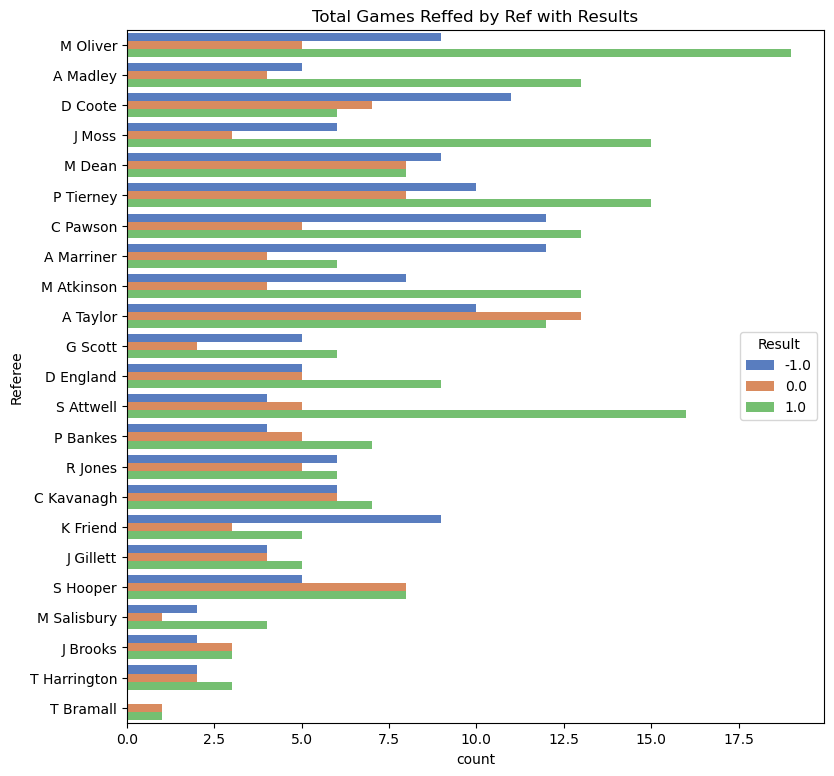

In [19]:
#Bar plot showing how many games each ref reffed
plt.figure(figsize=(9, 9))
sns.countplot(data = ref_impact, y="Referee", hue= 'Result', palette = 'muted')
plt.title("Total Games Reffed by Ref with Results")
plt.savefig(fname = '../figures/Total Games Reffed by Ref with Results', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

In [20]:
# percentage of value counts for target variable
final_dataset.Result.value_counts(normalize=True)

 1.0    0.437637
-1.0    0.319475
 0.0    0.242888
Name: Result, dtype: float64

In [21]:
#stats for final_dataset
final_dataset.describe().round(2)

,B365H,B365D,B365A,HICT,AICT,DifICT,Result
count,457.00,457.00,457.00,457.00,457.00,457.00,457.00
mean,3.03,4.24,4.66,8262.01,8226.76,35.24,0.12
std,2.32,1.45,4.39,505.94,496.46,590.51,0.86
min,1.06,2.80,1.14,7300.00,7300.00,-1473.20,-1.00
25%,1.61,3.40,2.15,7891.30,7864.20,-354.40,-1.00
50%,2.25,3.75,3.25,8198.50,8145.80,30.40,0.00
75%,3.40,4.50,5.50,8568.40,8515.20,415.00,1.00
max,19.00,13.00,29.00,9801.00,9809.20,1573.30,1.00


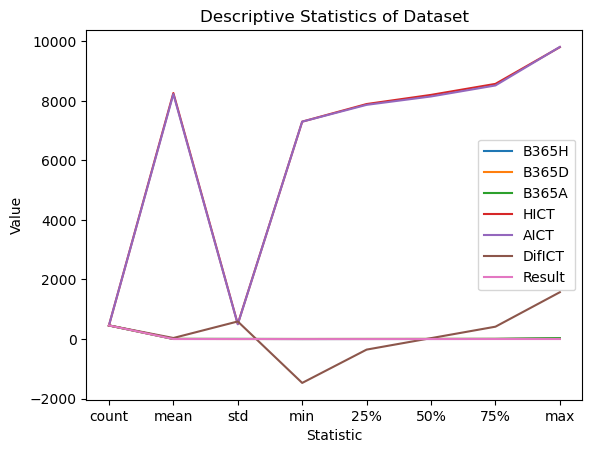

In [22]:
#stats for final_dataset plot
final_dataset.describe().round(2).plot()
plt.title("Descriptive Statistics of Dataset")
plt.ylabel("Value")
plt.xlabel("Statistic")
plt.savefig(fname = '../figures/Descriptive Statistics of Dataset', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

In [23]:
#info on final_dataset
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Referee  457 non-null    object 
 1   B365H    457 non-null    float64
 2   B365D    457 non-null    float64
 3   B365A    457 non-null    float64
 4   HICT     457 non-null    float64
 5   AICT     457 non-null    float64
 6   DifICT   457 non-null    float64
 7   Result   457 non-null    float64
dtypes: float64(7), object(1)
memory usage: 28.7+ KB


In [24]:
#calculates correlation between Result and other values
correlation = final_dataset.corr().abs().unstack()
correlation = correlation.sort_values(ascending=False)
correlation.Result

Result    1.000000
DifICT    0.419218
B365H     0.412218
B365A     0.360987
AICT      0.256969
HICT      0.237133
B365D     0.169424
dtype: float64

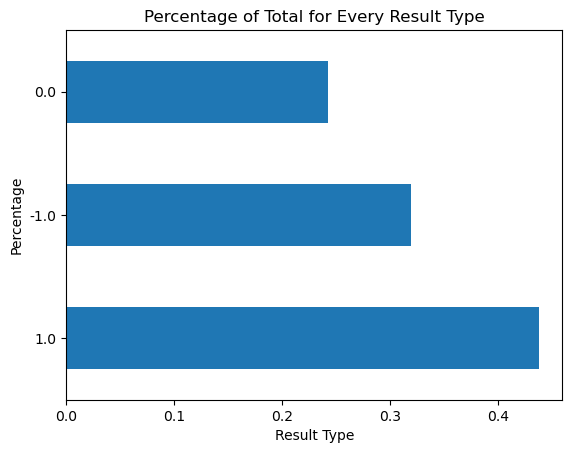

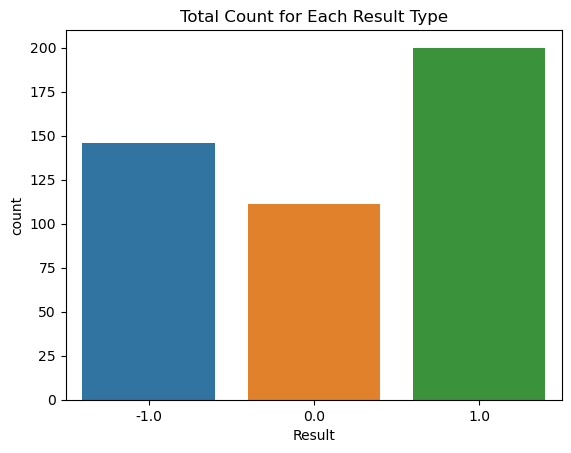

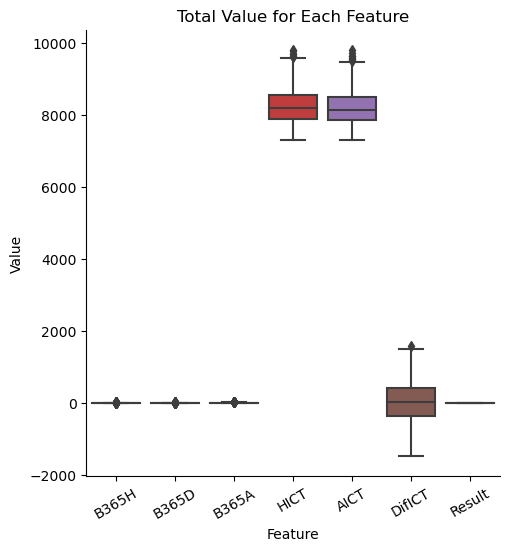

In [25]:
#count plots 
final_dataset.Result.value_counts(normalize=True).plot.barh()
plt.title("Percentage of Total for Every Result Type")
plt.savefig(fname = '../figures/Percentage of total for Each Result Type', format = 'png', dpi = 300, bbox_inches='tight')
plt.xlabel("Result Type")
plt.ylabel("Percentage")
plt.show()

count_plot = sns.countplot(x=final_dataset["Result"])
plt.title("Total Count for Each Result Type")
plt.savefig(fname = '../figures/Total Count for Each Result Type', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

fd_box = sns.catplot(data=final_dataset, kind="box")
fd_box.set_xticklabels(rotation=30)
plt.title("Total Value for Each Feature")
plt.ylabel("Value")
plt.xlabel("Feature")
plt.savefig(fname = '../figures/Total Value for Each Feature', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

In [26]:
#correlation between Result and specifc result outcomes
spearman = final_dataset[['Result', 'DifICT']].copy()
spearman['Home Wins']=(spearman['Result']==1.0).astype(int)
spearman['Away Wins']=(spearman['Result']==-1.0).astype(int)
spearman['Draw']=(spearman['Result']==0.0).astype(int)
my_r = spearman.corr(method="spearman")
print(my_r)

             Result    DifICT  Home Wins  Away Wins      Draw
Result     1.000000  0.406597   0.921626  -0.866223 -0.124334
DifICT     0.406597  1.000000   0.356479  -0.375703 -0.003887
Home Wins  0.921626  0.356479   1.000000  -0.604428 -0.499657
Away Wins -0.866223 -0.375703  -0.604428   1.000000 -0.388079
Draw      -0.124334 -0.003887  -0.499657  -0.388079  1.000000


In [27]:
spearman_noD = final_dataset[['Result', 'DifICT']].copy()
spearman_noD = spearman_noD[spearman_noD.Result != 0.0]
spearman_noD['Home Wins']=(spearman_noD['Result']==1.0).astype(int)
spearman_noD['Away wins']=(spearman_noD['Result']==-1.0).astype(int)
spearman_noD['Draw']=(spearman_noD['Result']==0.0).astype(int)
my_r = spearman_noD.corr(method="spearman")
print(my_r)

             Result    DifICT  Home Wins  Away wins  Draw
Result     1.000000  0.457151   1.000000  -1.000000   NaN
DifICT     0.457151  1.000000   0.457151  -0.457151   NaN
Home Wins  1.000000  0.457151   1.000000  -1.000000   NaN
Away wins -1.000000 -0.457151  -1.000000   1.000000   NaN
Draw            NaN       NaN        NaN        NaN   NaN


In [28]:
spearman_win_draw = final_dataset[['Result', 'DifICT']].copy()
spearman_win_draw['Away Wins/Draws']=(spearman_win_draw['Result']!=1.0).astype(int)
spearman_win_draw['Home Wins/Draws']=(spearman_win_draw['Result']!=-1.0).astype(int)
my_r = spearman_win_draw.corr(method="spearman")
print(my_r)

                   Result    DifICT  Away Wins/Draws  Home Wins/Draws
Result           1.000000  0.406597        -0.921626         0.866223
DifICT           0.406597  1.000000        -0.356479         0.375703
Away Wins/Draws -0.921626 -0.356479         1.000000        -0.604428
Home Wins/Draws  0.866223  0.375703        -0.604428         1.000000


In [29]:
def display_correlation(df):
    r = df.corr(method="spearman")
    plt.figure(figsize=(10,6))
    heatmap = sns.heatmap(df.corr(), vmin=-1, 
                      vmax=1, annot=True)
    plt.title("Spearman Correlation - Result Types and DifICT")
    return(r)

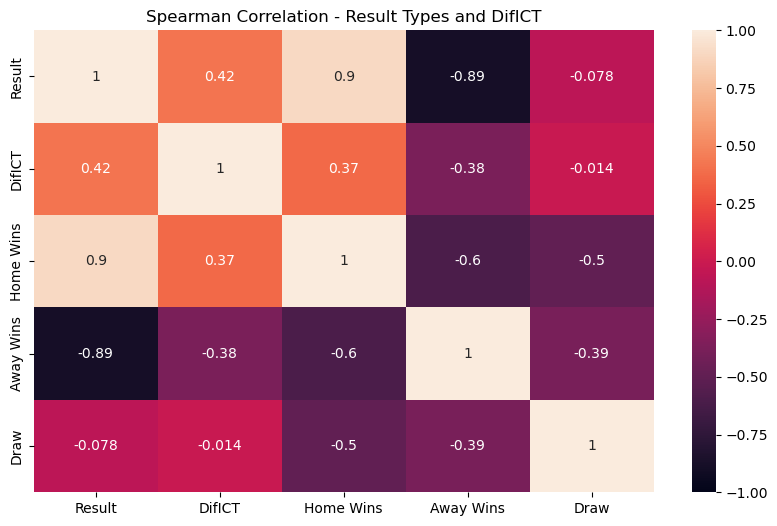

In [30]:
r_simple=display_correlation(spearman)
plt.savefig(fname = '../figures/Spearman Correlation', format = 'png', dpi = 300, bbox_inches='tight')

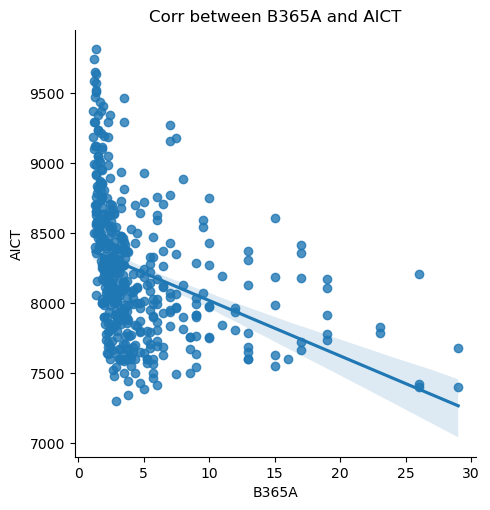

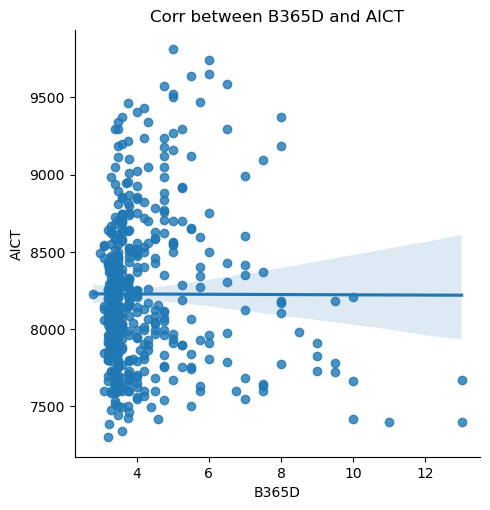

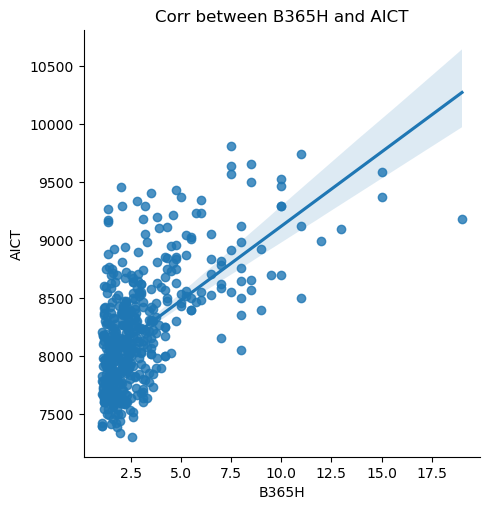

In [31]:
#scatter plots between odds and AICT
sns.lmplot(x='B365A',y='AICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365A and AICT")
plt.savefig(fname = '../figures/Corr between B365A and AICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365D',y='AICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365D and AICT")
plt.savefig(fname = '../figures/Corr between B365D and AICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365H',y='AICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365H and AICT")
plt.savefig(fname = '../figures/Corr between B365H and AICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

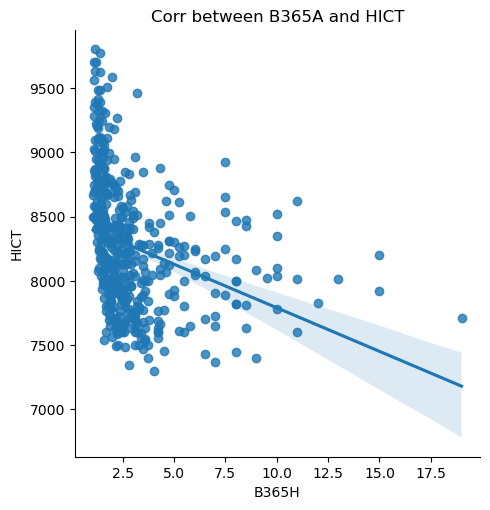

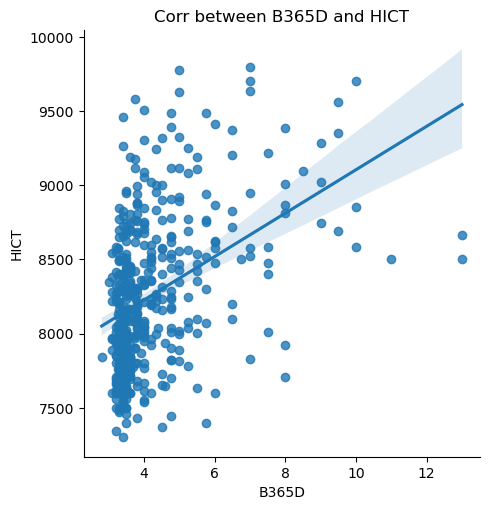

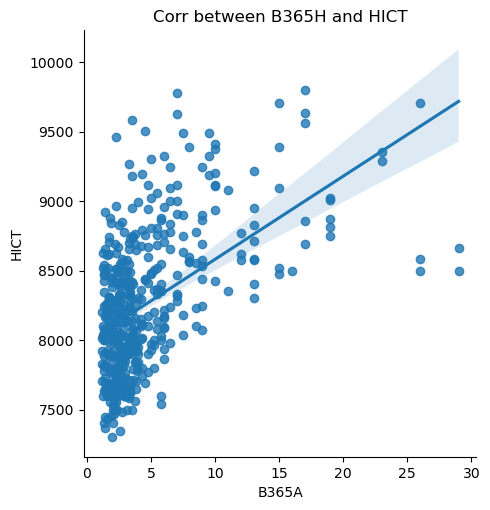

In [32]:
#scatter plots between odds and HICT
sns.lmplot(x='B365H',y='HICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365A and HICT")
plt.savefig(fname = '../figures/Corr between B365A and HICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365D',y='HICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365D and HICT")
plt.savefig(fname = '../figures/Corr between B365D and HICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365A',y='HICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365H and HICT")
plt.savefig(fname = '../figures/Corr between B365H and HICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

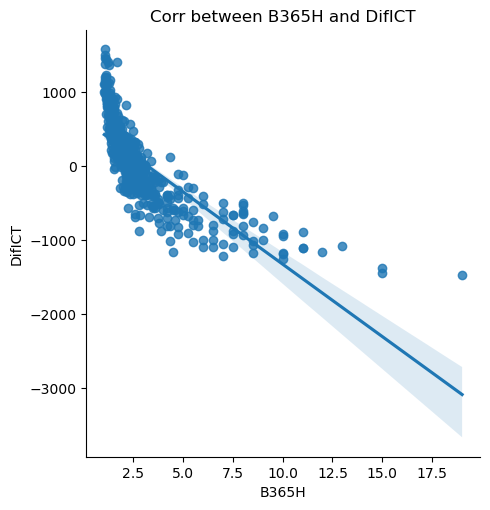

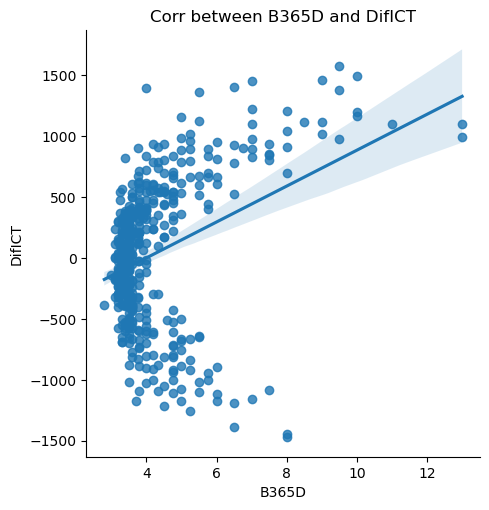

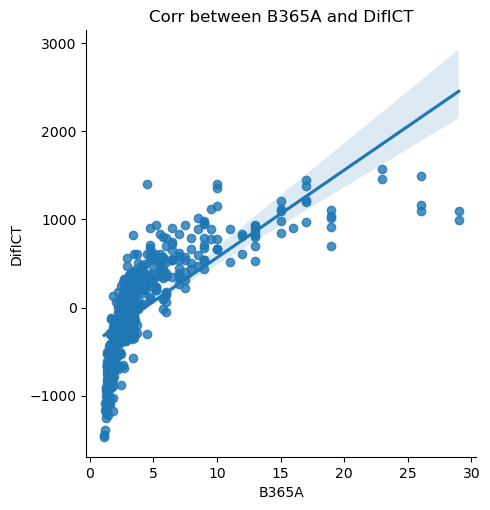

In [33]:
#scatter plots between odds and DifICT
sns.lmplot(x='B365H',y='DifICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365H and DifICT")
plt.savefig(fname = '../figures/Corr between B365H and DifICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365D',y='DifICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365D and DifICT")
plt.savefig(fname = '../figures/Corr between B365D and DifICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365A',y='DifICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365A and DifICT")
plt.savefig(fname = '../figures/Corr between B365A and DifICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

/Users/nikolaistambler/opt/anaconda3/envs/DATA1030/lib/python3.10/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/nikolaistambler/opt/anaconda3/envs/DATA1030/lib/python3.10/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


[ 0.99781182 -0.00707661  0.06121283 -0.06239719  0.04126072  0.00591132
  0.03895573  0.01011961 -0.04004851 -0.00469456]


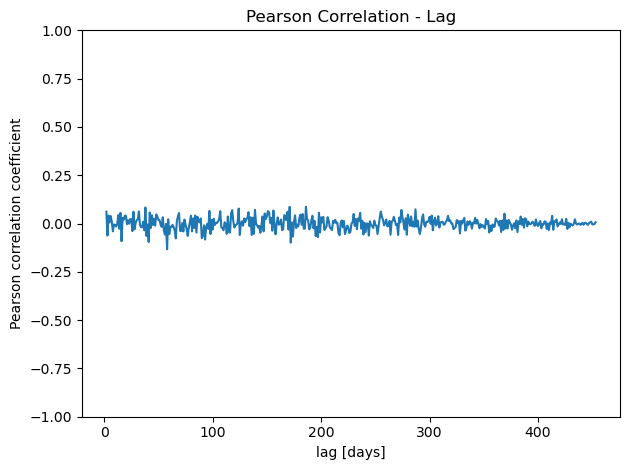

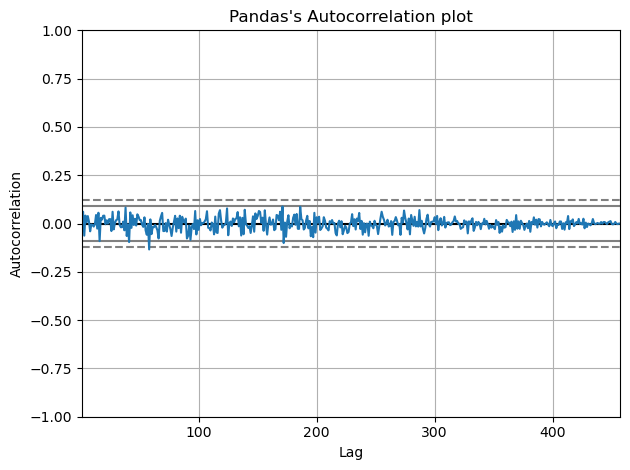

In [34]:
#auto correlation plot
lags = np.arange(457)
corr_coefs = np.zeros(457)

for i in np.arange(len(lags)):
    x = final_dataset['Result'].iloc[i:-1].reset_index(drop=True) # recent observations
    y = final_dataset['Result'].iloc[:-i-1].reset_index(drop=True) # lag-shifted observations
    # the shapes must be the same
    if x.shape != y.shape:
        raise ValueError('shape mismatch!')
    # Pearson correlation multiplied by the fraction of time series used
    corr_coefs[i] = x.corr(y,method='pearson')*x.shape[0]/final_dataset['Result'].shape[0]
print(corr_coefs[:10])

pearson_corr_lag = plt.plot(lags[2:],corr_coefs[2:])
plt.ylim([-1,1])
plt.xlabel('lag [days]')
plt.ylabel('Pearson correlation coefficient')
plt.title('Pearson Correlation - Lag')
plt.tight_layout()
plt.savefig(fname = '../figures/Pearson Correlation - Lag', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

# a one-liner
panda_auto_corr = pd.plotting.autocorrelation_plot(final_dataset['Result'])
plt.title("Pandas's Autocorrelation plot")
plt.tight_layout()
plt.savefig(fname = '../figures/Pandas Autocorrelation plot', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

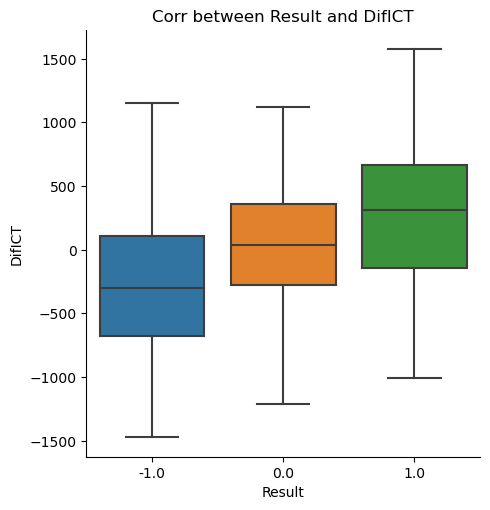

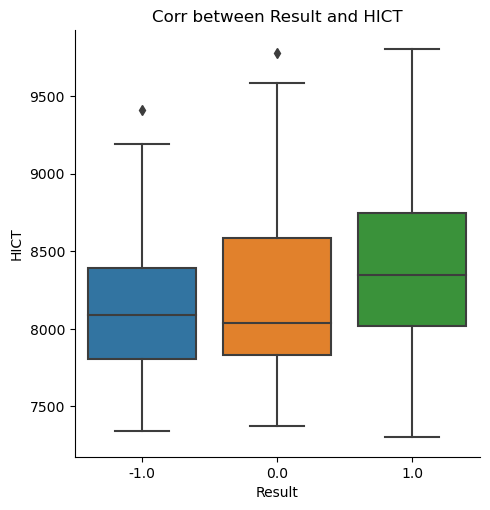

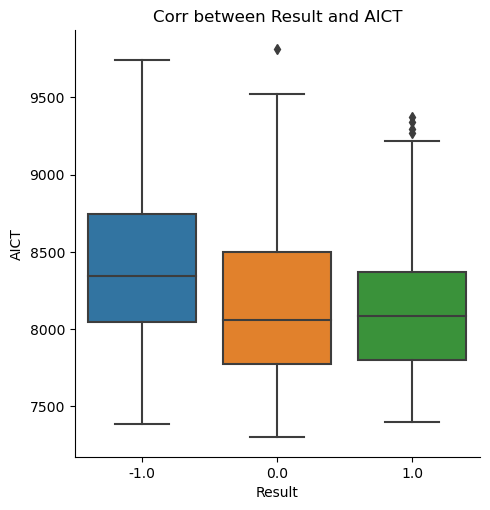

In [35]:
#box plot for result variable with DifICT, HICT, AICT
sns.catplot(data=final_dataset, x="Result", y="DifICT", kind="box")
plt.title("Corr between Result and DifICT")
plt.savefig(fname = '../figures/Corr between Result and DifICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.catplot(data=final_dataset, x="Result", y="HICT", kind="box")
plt.title("Corr between Result and HICT")
plt.savefig(fname = '../figures/Corr between Result and HICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.catplot(data=final_dataset, x="Result", y="AICT", kind="box")
plt.title("Corr between Result and AICT")
plt.savefig(fname = '../figures/Corr between Result and AICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

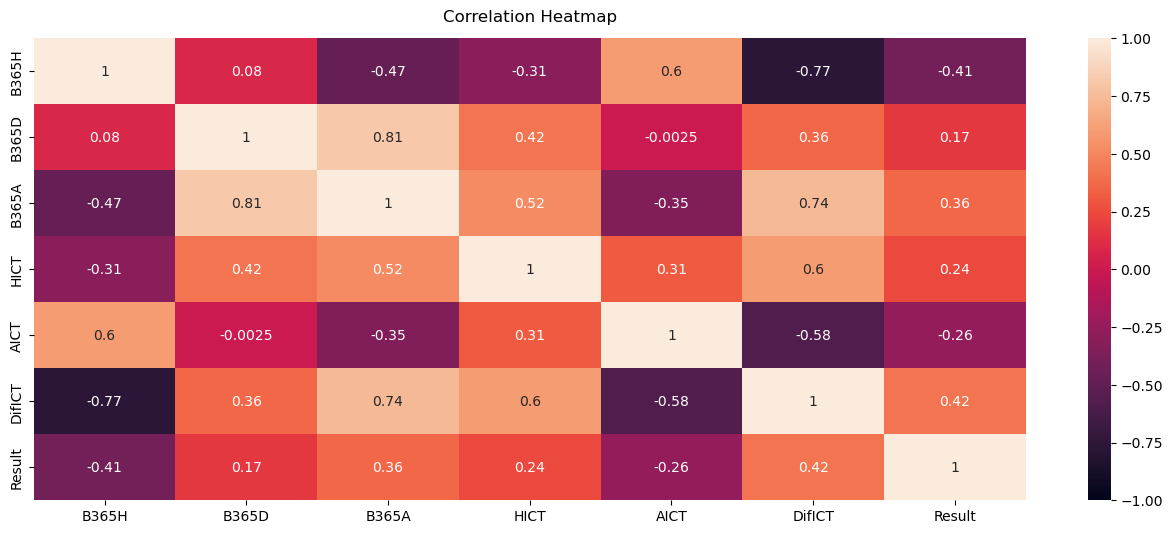

In [36]:
#Correlation Heatmap of all features
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(final_dataset.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig(fname = '../figures/Correlation Heatmap - All Features', format = 'png', dpi = 300, bbox_inches='tight')

In [37]:
#pointbiserial
from scipy.stats import pointbiserialr

copy = final_dataset
copy = copy.drop('Result', axis=1)
copy = copy.drop('Referee', axis=1)
result = final_dataset.copy()

from scipy import stats
corr_list = []
y = result['Result'].astype(float)

for column in copy:
    x=copy[column]
    corr = stats.pointbiserialr(list(x), list(y))
    corr_list.append(corr[0])
print(corr_list)

[-0.41221816029361436, 0.16942449104528334, 0.3609873022870327, 0.23713297665884991, -0.25696913103474944, 0.41921754451477955]


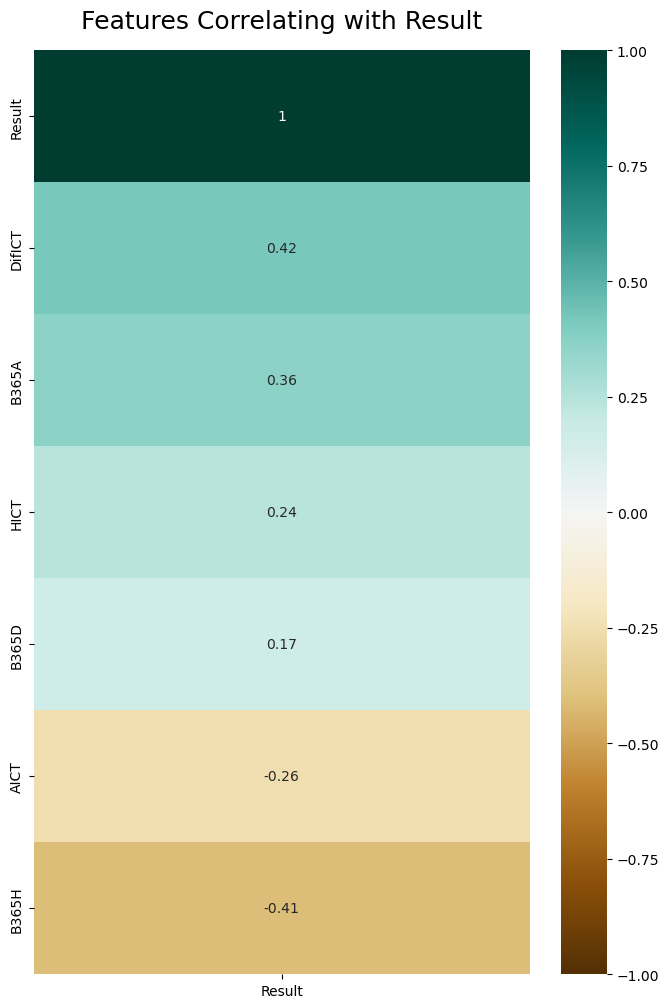

In [38]:
#Correlation Heatmap of all features with target variable
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(final_dataset.corr()[['Result']].sort_values(by='Result', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Result', fontdict={'fontsize':18}, pad=16);
plt.savefig(fname = '../figures/Features Correlating with Result', format = 'png', dpi = 300, bbox_inches='tight')

# Lagging

In [39]:
#features to lag
Referee = final_dataset['Referee']
Result = final_dataset['Result']
B365H = final_dataset['B365H']
B365D = final_dataset['B365D']
B365A = final_dataset['B365A']
HICT = final_dataset['HICT']
AICT = final_dataset['AICT']
DifICT = final_dataset['DifICT']

y = final_dataset['Result']
X = pd.concat([Referee, Result, B365H.shift(5),B365H.shift(4),B365H.shift(3),B365H.shift(2),
               B365H.shift(1),B365H, B365D.shift(5),B365D.shift(4),B365D.shift(3),
               B365D.shift(2),B365D.shift(1),B365D, B365A.shift(5),B365A.shift(4),
               B365A.shift(3),B365A.shift(2),B365A.shift(1),B365A, HICT.shift(5),
               HICT.shift(4),HICT.shift(3),HICT.shift(2),HICT.shift(1),HICT, 
               AICT.shift(5),AICT.shift(4),AICT.shift(3),AICT.shift(2),AICT.shift(1),AICT, 
               DifICT.shift(5),DifICT.shift(4),DifICT.shift(3),DifICT.shift(2),DifICT.shift(1),DifICT],
              axis=1)

X.columns = ['Referee', 'Result',
             
             'B365H lag 5 matches', 'B365H lag 4 matches', 'B365H lag 3 matches', 
             'B365H lag 2 matches', 'B365H lag 1 match', ' B365H most recent match',
             
             'B365D lag 5 matches', 'B365D lag 4 matches', 'B365D lag 3 matches', 
             'B365D lag 2 matches', 'B365D lag 1 match', ' B365D most recent match',
             
             'B365A lag 5 matches', 'B365A lag 4 matches', 'B365A lag 3 matches', 
             'B365A lag 2 matches', 'B365A lag 1 match', ' B365A most recent match',       
             
             'HICT lag 5 matches', 'HICT lag 4 matches', 'HICT lag 3 matches', 
             'HICT lag 2 matches', 'HICT lag 1 match', ' HICT most recent match',       
             
             'AICT lag 5 matches', 'AICT lag 4 matches', 'AICT lag 3 matches', 
             'AICT lag 2 matches', 'AICT lag 1 match', ' AICT most recent match',
             
             'DifICT lag 5 matches', 'DifICT lag 4 matches', 'DifICT lag 3 matches', 
             'DifICT lag 2 matches', 'DifICT lag 1 match', ' DifICT most recent match'] 

print(X.tail(10))
print(y.tail(10))

          Referee  Result  B365H lag 5 matches  B365H lag 4 matches  \
447      S Hooper     1.0                 2.15                 3.30   
448      J Brooks     1.0                 3.30                 2.35   
449      A Madley     1.0                 2.35                 1.33   
450   M Salisbury     1.0                 1.33                 1.75   
451  T Harrington    -1.0                 1.75                 1.40   
452      M Oliver     1.0                 1.40                 1.83   
453     P Tierney     1.0                 1.83                 1.11   
454    C Kavanagh     1.0                 1.11                 3.60   
455       D Coote    -1.0                 3.60                 2.80   
456      A Taylor     0.0                 2.80                 2.50   

     B365H lag 3 matches  B365H lag 2 matches  B365H lag 1 match  \
447                 2.35                 1.33               1.75   
448                 1.33                 1.75               1.40   
449           

# Splitting

In [40]:
#create dataframe for splitting
df_for_splitting = X.iloc[5:].reset_index(drop = True)
df_for_splitting

# create training set
df_train = df_for_splitting.iloc[:271]

y_train = df_train['Result']
X_train = df_train.loc[:,df_train.columns!= 'Result']

#create validation set
df_val = df_for_splitting.iloc[271:362]

y_val = df_val['Result']
X_val = df_val.loc[:,df_val.columns!='Result']

#create test set
df_test = df_for_splitting.iloc[362:]

y_test = df_test['Result']
X_test = df_test.loc[: ,df_test.columns!='Result']

#check each sets size
print ('Number of datapoints in training set:', X_train.shape[0])
print ( 'Percent of data in training set:{0:1.1f}'.format((X_train.shape[0]/df_for_splitting.shape[0])*100),)

print ('\nNumber of datapoints in validation set:', X_val.shape[0])
print ( 'Percent of data in validation set:{0:1.1f}'.format((X_val.shape[0]/df_for_splitting.shape[0])*100),)

print ('\nNumber of datapoints in test set:',X_test.shape[0])
print ( 'Percent of data in test set:{0:1.1f}'.format((X_test.shape[0]/df_for_splitting.shape[0])*100),)

Number of datapoints in training set: 271
Percent of data in training set:60.0

Number of datapoints in validation set: 91
Percent of data in validation set:20.1

Number of datapoints in test set: 90
Percent of data in test set:19.9


# Encoding

In [41]:
# collect which encoder to use on each feature
onehot_ftrs = ['Referee']
minmax_ftrs = ['HICT lag 5 matches', 'HICT lag 4 matches', 'HICT lag 3 matches', 
               'HICT lag 2 matches', 'HICT lag 1 match', ' HICT most recent match',       
            
               'AICT lag 5 matches', 'AICT lag 4 matches', 'AICT lag 3 matches', 
               'AICT lag 2 matches', 'AICT lag 1 match', ' AICT most recent match']
               
std_ftrs = ['B365H lag 5 matches', 'B365H lag 4 matches', 'B365H lag 3 matches', 
            'B365H lag 2 matches', 'B365H lag 1 match', ' B365H most recent match',
             
            'B365D lag 5 matches', 'B365D lag 4 matches', 'B365D lag 3 matches', 
            'B365D lag 2 matches', 'B365D lag 1 match', ' B365D most recent match',
             
            'B365A lag 5 matches', 'B365A lag 4 matches', 'B365A lag 3 matches', 
            'B365A lag 2 matches', 'B365A lag 1 match', ' B365A most recent match',       
             
            'DifICT lag 5 matches', 'DifICT lag 4 matches', 'DifICT lag 3 matches', 
            'DifICT lag 2 matches', 'DifICT lag 1 match', ' DifICT most recent match']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)]) 
                                                

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

print(X_train.shape)
print(X_val_prep.shape)
print(X_test_prep)

(271, 37)
(91, 58)
[[ 0.          0.          1.         ... -0.70817337 -1.90540683
   0.57515742]
 [ 0.          0.          0.         ... -1.90414451  0.58010785
   0.67379666]
 [ 0.          0.          0.         ...  0.57592375  0.67878792
   0.81946357]
 ...
 [ 0.          0.          0.         ... -0.67715981  0.01197565
   0.60588669]
 [ 0.          0.          0.         ...  0.00903648  0.61084983
  -0.72396046]
 [ 0.          0.          1.         ...  0.60659837 -0.71954763
  -0.5285495 ]]
